# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tfds = tf.data.Dataset
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets as datasets
from PIL import Image
import sys
import time
import contextlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Load

In [0]:
IMAGE_SIZE = 14
IMAGE_RESCALE = 2

In [0]:
def downsample(images, size=(IMAGE_SIZE,IMAGE_SIZE), rescale=IMAGE_RESCALE):
  for img in images.astype(np.float32):
    img = Image.fromarray(img).resize(size, resample=rescale)
    yield np.expand_dims(np.array(img), axis=0)

In [0]:
mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = np.vstack(list(downsample(x_train)))
x_test = np.vstack(list(downsample(x_test)))

x_train = (x_train.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
x_test = (x_test.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

x_train, x_valid, t_train, t_valid = train_test_split(x_train, t_train, test_size=10000, random_state=0, shuffle=True, stratify=t_train)

## Pipeline

In [0]:
TRAIN_BATCH_SIZE = 500
TRAIN_SAMPLE_SIZE = TRAIN_BATCH_SIZE*10
VALID_BATCH_SIZE = 1000

mnist_train = tfds.from_tensor_slices((x_train, t_train))
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)
mnist_train = mnist_train.shuffle(TRAIN_SAMPLE_SIZE, seed=0, reshuffle_each_iteration=True)
mnist_train = mnist_train.batch(TRAIN_BATCH_SIZE, drop_remainder=True)

mnist_valid = tfds.from_tensor_slices((x_valid, t_valid))
mnist_valid = mnist_valid.shuffle(len(x_valid), seed=0, reshuffle_each_iteration=True)
mnist_valid = mnist_valid.batch(VALID_BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.from_tensor_slices((x_test, t_test))
mnist_test = mnist_test.batch(VALID_BATCH_SIZE, drop_remainder=False)

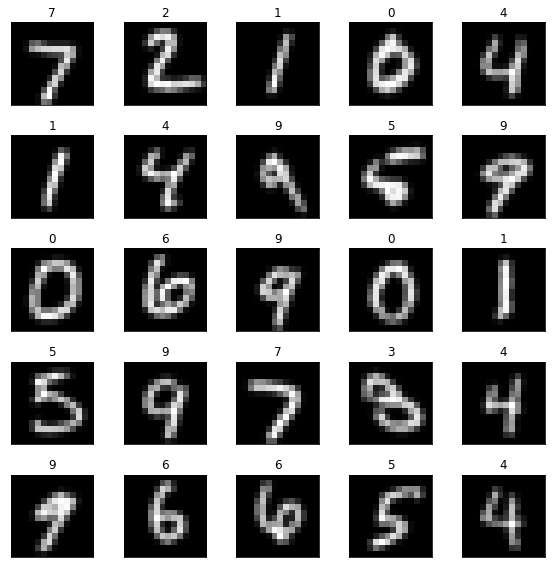

In [9]:
n = 5
fig, axes = plt.subplots(n,n,figsize=[8,8])

for img, lab, ax in zip(x_test, t_test, np.ravel(axes)):
  img = img.reshape(IMAGE_SIZE,IMAGE_SIZE)
  lab = np.argmax(lab)
  ax.imshow(img,cmap='gray')
  ax.set_title(lab)
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()

# Model

## MLP for ODE

In [0]:
NUM_HIDDEN_UNITS = 64
NUM_HIDDEN_LAYERS = 2
DIM_INPUTS = IMAGE_SIZE**2 # dim_output must be equal to dim_input in time_derivative_fn of ODE 

class MLP_ODE(tfk.Model):
  def __init__(self):
    super(MLP_ODE, self).__init__()
    self._layers = []
    for _ in range(NUM_HIDDEN_LAYERS):
      self._layers.append(tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh'))
    self._layers.append(tfkl.Dense(DIM_INPUTS))
  
  def call(self, t, inputs):
    x = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    for l in self._layers: x = l(x)
    return x

## ODE Network

In [0]:
DIM_OUTPUTS = 10

class OdeNet(tfk.Model):

  def __init__(self, num_stacked_ffjords, atol=1e-5):
    super(OdeNet, self).__init__()
    self._num_stacked_ffjords = num_stacked_ffjords

    # Make a chain of bijectors
    solver = tfp.math.ode.DormandPrince(atol=atol)
    trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
    
    bijectors = []
    for _ in range(self._num_stacked_ffjords):
      next_ffjord = tfb.FFJORD(
          state_time_derivative_fn=MLP_ODE(),
          ode_solve_fn=solver.solve,
          trace_augmentation_fn=trace_augmentation_fn)
      bijectors.append(next_ffjord)
    # tfb.Chain takes a list of bijectors in the reverse order where they are applied
    self._stacked_ffjord = tfb.Chain(bijectors[::-1])
    
    # Make the top layers
    self._top_layers = [tfkl.Dense(2, activation=None), tfkl.Dense(DIM_OUTPUTS, activation='softmax'),]
    # To visualize the fetures, they are projected onto 2d plane and then probs are calculated.
  
  def forward(self, x):
    if self._num_stacked_ffjords > 0:
      return self._stacked_ffjord.forward(x)
    return x
  
  def project2d(self, x):
    x = self.forward(x)
    return self._top_layers[0](x)

  def call(self, x):
    x = self.forward(x)
    for l in self._top_layers: x = l(x)
    return x

# Train

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Trainer

In [0]:
class ModelTrainer():

  def __init__(self, classifier, optimizer):
    self.classifier = classifier
    self.optimizer = optimizer
    # The following methods look static,
    # but an instance of ModelTrainer has their graphs internally.
    # See @tf.function document in details.
  

  def calc_loss_and_acc(self, x, t):
    p = self.classifier(x)
    loss = tf.reduce_mean(tfk.losses.categorical_crossentropy(t, p))
    acc = tf.reduce_mean(tfk.metrics.categorical_accuracy(t, p))
    return loss, acc

  
  @tf.function
  def train_step(self, x, t):
    with tf.GradientTape() as tape:
      loss, acc = self.calc_loss_and_acc(x, t)
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    return loss, acc

## Optimization

In [0]:
ode_net_depth0 = OdeNet(num_stacked_ffjords=0)
ode_net_depth1 = OdeNet(num_stacked_ffjords=1, atol=1e-4)
ode_net_depth2 = OdeNet(num_stacked_ffjords=2, atol=1e-4)

In [15]:
LR = 3e-3
NUM_EPOCHS = 30

lst_name = ['ode_net_depth0','ode_net_depth1','ode_net_depth2']
lst_model = [ode_net_depth0,ode_net_depth1,ode_net_depth2]
lst_val_loss = []
lst_val_acc = []

for name, model in zip(lst_name, lst_model):
  print('\n', name)
  trainer = ModelTrainer(model, tfk.optimizers.Adam(LR))
  val_loss, val_acc = [], []
  
  with measure_time(), overwriting_stdout():
    for epoch, valid_data in zip(range(NUM_EPOCHS), mnist_valid.repeat()):
      # Train ODE Net
      for x, t in mnist_train:
        _, _ = trainer.train_step(x, t)
      
      # Calc validation loss
      l, a = trainer.calc_loss_and_acc(valid_data[0], valid_data[1])
      val_loss.append(l)
      val_acc.append(a)
      sys.stdout.write('Epoch {0}: Val Loss = {1:.3f}, Val Acc = {2:.3f}'.format(epoch+1, l, a))
  
  lst_val_loss.append(val_loss)
  lst_val_acc.append(val_acc)


 ode_net_depth0
Epoch 30: Val Loss = 0.969, Val Acc = 0.704
Elapsed Time 8.986845 [sec]

 ode_net_depth1
Epoch 30: Val Loss = 0.282, Val Acc = 0.949
Elapsed Time 1013.679508 [sec]

 ode_net_depth2
Epoch 30: Val Loss = 0.234, Val Acc = 0.955
Elapsed Time 1530.799292 [sec]


## Learning Curves

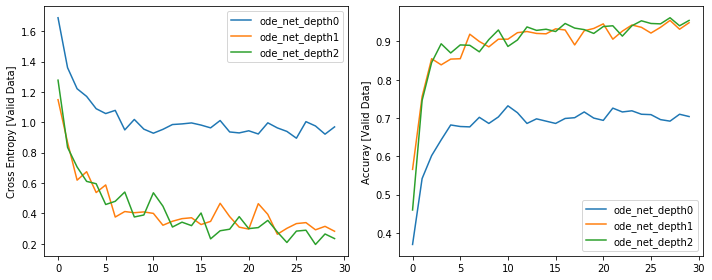

In [16]:
fig, axes = plt.subplots(1,2,sharex=True,figsize=[10,4])

for name,loss,acc in zip(lst_name,lst_val_loss,lst_val_acc):
  axes[0].plot(loss, label=name)
  axes[0].set_ylabel('Cross Entropy [Valid Data]')
  axes[1].plot(acc, label=name)
  axes[1].set_ylabel('Accuray [Valid Data]')

for ax in axes: ax.legend()
plt.tight_layout()
plt.show()

# Results

## Model Evaluation

In [0]:
def calc_loss_and_acc(t, p):
    loss = tf.reduce_mean(tfk.losses.categorical_crossentropy(t, p))
    acc = tf.reduce_mean(tfk.metrics.categorical_accuracy(t, p))
    return loss, acc


dic_loss, dic_acc, dic_preds, dic_latents = {}, {}, {}, {}

# To avoid running out of GPU memory, tf.data.Dataset pipline is used.
for name, model in zip(lst_name, lst_model):

  loss, acc, preds, latents = [], [], [], []
  for x, t in mnist_test:
    p = model(x)
    l, a = calc_loss_and_acc(t, p)
    preds.append(p.numpy())
    loss.append(l)
    acc.append(a)

    lt = model.project2d(x).numpy()
    latents.append(lt)
  
  dic_loss[name] = np.array(loss).mean()
  dic_acc[name] = np.array(acc).mean()
  dic_preds[name] = np.vstack(preds)
  dic_latents[name] = np.vstack(latents)

In [18]:
for name in lst_name:
  l = dic_loss[name]
  a = dic_acc[name]
  print('{0}: Test Loss = {1:.3f}, Test Acc = {2:.3f}'.format(name, l, a))

ode_net_depth0: Test Loss = 0.971, Test Acc = 0.700
ode_net_depth1: Test Loss = 0.291, Test Acc = 0.942
ode_net_depth2: Test Loss = 0.276, Test Acc = 0.951


## Predictions

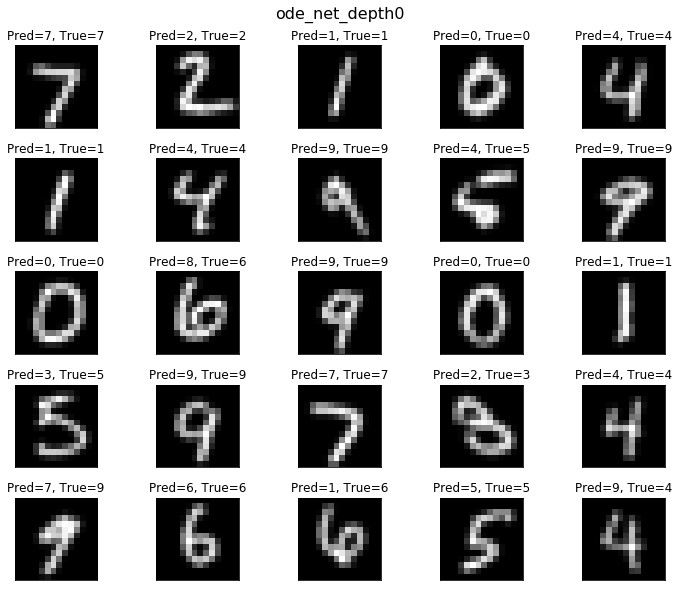

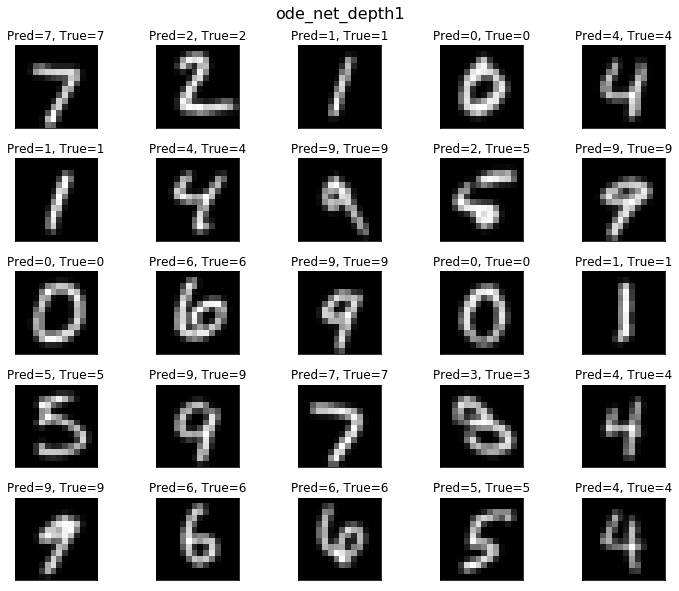

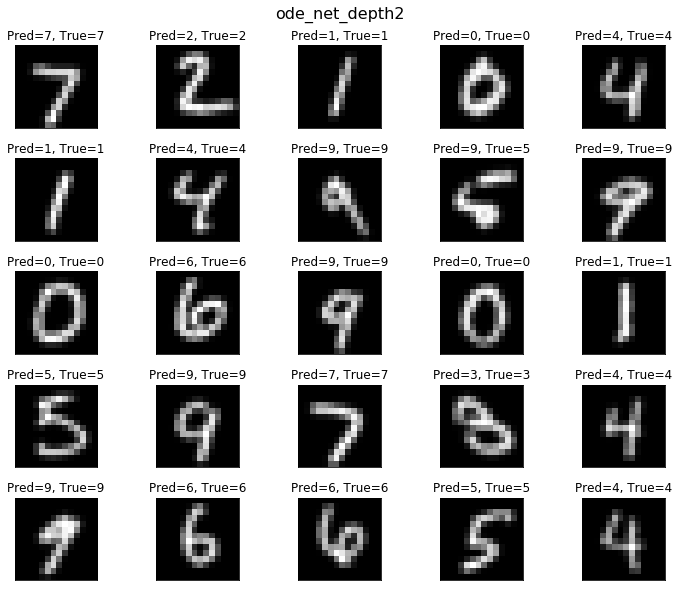

In [33]:
n = 5

for name, preds in dic_preds.items():
  fig, axes = plt.subplots(n,n,figsize=[10,8])
  fig.suptitle(name, y=1.02, fontsize=16)
  for img, lab, prd, ax in zip(x_test, t_test, preds, np.ravel(axes)):
    img = img.reshape(IMAGE_SIZE,IMAGE_SIZE)
    ax.imshow(img,cmap='gray')
    ax.set_title('Pred={}, True={}'.format(np.argmax(prd), np.argmax(lab)))
    ax.set_xticks([])
    ax.set_yticks([])
  fig.tight_layout()
  fig.show()

## 2D Latent Spaces

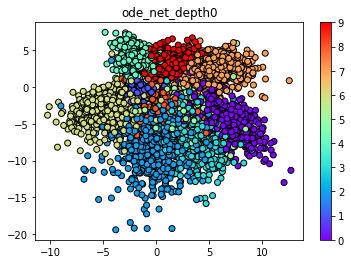

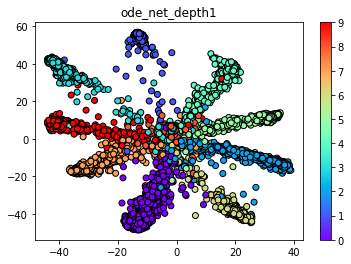

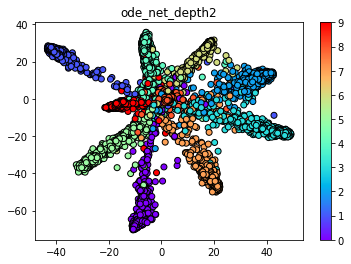

In [20]:
for name, latents in dic_latents.items(): 
  lab = np.argmax(t_test, axis=1)
  plt.scatter(latents[:,0], latents[:,1], c=lab, alpha=1.,
              cmap='rainbow', marker='o', edgecolors='k')
  plt.colorbar()
  plt.title(name)
  plt.show()

# References

1. https://arxiv.org/abs/1806.07366
1. https://arxiv.org/abs/1810.01367